In [1]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
train_path = "/kaggle/input/comsys/Comys_Hackathon5/Task_A/train"
val_path = "/kaggle/input/comsys/Comys_Hackathon5/Task_A/val"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
train_transforms = transforms.Compose([
transforms.Resize((224, 224)),
transforms.RandomHorizontalFlip(),
transforms.ColorJitter(brightness=0.2, contrast=0.2),
transforms.ToTensor(),
transforms.Normalize(mean=[0.485, 0.456, 0.406],
std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [5]:
train_dataset = datasets.ImageFolder(train_path, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_path, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [6]:
import torch.nn as nn
from torchvision import models

model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
# for param in model.layer4.parameters():
#     param.requires_grad = True

model.fc = nn.Sequential(
nn.Linear(model.fc.in_features, 256),
nn.ReLU(),
nn.Dropout(0.4),
nn.Linear(256, 2)
)

model = model.to(device)

# optimizer = torch.optim.Adam([
#     {'params': model.fc.parameters(), 'lr': 1e-3},
#     {'params': model.layer4.parameters(), 'lr': 1e-4}
# ])

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3, factor=0.5)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 178MB/s] 


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-4)

In [10]:
def train_model(num_epochs=10):
    for epoch in range(num_epochs):
   
        model.train()
        running_loss, running_correct = 0.0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * images.size(0)
            running_correct += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_correct.double() / len(train_dataset)

       
        model.eval()
        val_running_loss, val_running_correct = 0.0, 0
        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_labels)

                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item() * val_images.size(0)
                val_running_correct += torch.sum(val_preds == val_labels.data)

        val_epoch_loss = val_running_loss / len(val_dataset)
        val_epoch_acc = val_running_correct.double() / len(val_dataset)

        print(
            f"Epoch [{epoch+1}/{num_epochs}], "
            f"Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, "
            f"Val_Loss: {val_epoch_loss:.4f}, Val_Acc: {val_epoch_acc:.4f}"
        )

In [13]:
train_model(num_epochs=10)

Epoch [1/10], Loss: 0.1358, Acc: 0.9439, Val_Loss: 0.2170, Val_Acc: 0.9171
Epoch [2/10], Loss: 0.1487, Acc: 0.9387, Val_Loss: 0.2189, Val_Acc: 0.9123
Epoch [3/10], Loss: 0.1504, Acc: 0.9403, Val_Loss: 0.2349, Val_Acc: 0.9194
Epoch [4/10], Loss: 0.1376, Acc: 0.9486, Val_Loss: 0.2221, Val_Acc: 0.9171
Epoch [5/10], Loss: 0.1467, Acc: 0.9398, Val_Loss: 0.2202, Val_Acc: 0.9147
Epoch [6/10], Loss: 0.1374, Acc: 0.9413, Val_Loss: 0.2625, Val_Acc: 0.9052
Epoch [7/10], Loss: 0.1335, Acc: 0.9450, Val_Loss: 0.2169, Val_Acc: 0.9123
Epoch [8/10], Loss: 0.1255, Acc: 0.9512, Val_Loss: 0.2114, Val_Acc: 0.9123
Epoch [9/10], Loss: 0.1326, Acc: 0.9450, Val_Loss: 0.2119, Val_Acc: 0.9123
Epoch [10/10], Loss: 0.1472, Acc: 0.9429, Val_Loss: 0.2185, Val_Acc: 0.9171


              precision    recall  f1-score   support

      female       0.83      0.70      0.76        79
        male       0.93      0.97      0.95       343

    accuracy                           0.92       422
   macro avg       0.88      0.83      0.85       422
weighted avg       0.91      0.92      0.91       422



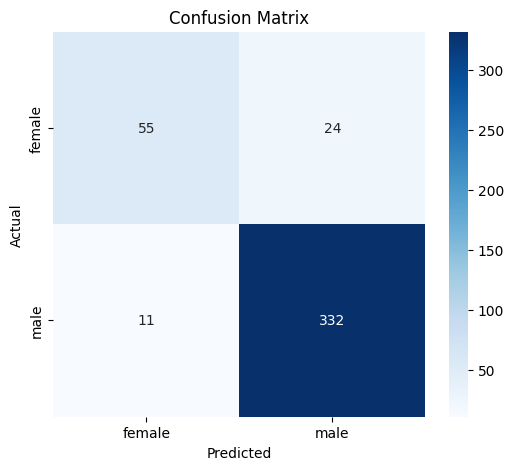

In [14]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=train_dataset.classes))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=train_dataset.classes, yticklabels=train_dataset.classes, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()



torch.save(model, 'resnet50_finetuned_full2.pth')